<h1><center>Clustering Analysis of Curveballs in NCAA Division I Baseball</center></h1>

<center> Matthew Coleman, Tony Ortiz, Taylor Villahermosa <center>

<center> December 12th, 2019 <center>


# 1 Abstract

The goal of our analysis is to compare the effectiveness of different types of curveballs through cluster analysis. We analyzed TrackMan data containing ball measurements from all NCAA D1 baseball teams which have TrackMan radar systems. We used K-Means and Gaussian Mixture clustering to cluster curveballs based on multiple pitch characteristics. After labeling our data with the cluster number, we compared pitch success by calculating whiff rates and exit velocity by cluster. We were able to discover that curveball clustering focuses mostly on movement, and that movement leads to different success rates based on handedness match-ups. The differences in success between clusters is often statistically significant but not always useful. Other results we encountered during our analysis led us to choosing more specific constraints which make our research easier to apply on an individual player basis. We encountered issues when applying clustering to fairly distributed data, so we proposed considering future analysis with different methods. 

# 2 Introduction 

The competitive nature of baseball leads to teams being secretive with findings in pitch design, but independent bloggers, researchers, and training companies such as Driveline have begun publishing new discoveries. Derek Carty began the field of pitch design by  [1] investigating the effectiveness of different types of curveballs in 2008 using PITCHf/x data, data known to be less accurate than data now. His study focused primarily on movement, location, and “hump size.”  Although his techniques were rudimentary, he was able to discover features which led to more effective curveballs. The main drawback of Carty’s research is that he chose to analyze at most two factors at a time instead of analyzing all the variables and their interactions. More recent research done by Travis Sawchik [2] suggests total ball movement has increased: more drop for curveballs, more horizontal “glove-side” run for sliders. Despite this, pitch velocity has not changed significantly. Sawchik believes the additional movement is one of the reasons the strikeout rates have increased in recent years. Carty and Sawchik’s research hint at pitch features that could delineate characteristics of a successful curveball, but both cases do not provide analysis of more overlooked variables such as spin rate and extension. We hope to explore these ‘hidden’ variables through unsupervised cluster analysis on TrackMan pitch data.

We were able to collect data from multiple NCAA Division I baseball teams through the TrackMan data sharing program. The structured CSV dataset contains both situational variables (batter, pitcher, date, count, inning etc) and ball flight measurements (release speed, spin rate etc.). This dataset will allow us to analyze various factors that influence the type of pitch while also measuring offensive features which can be used to measure curveball effectiveness within each cluster. This dataset is also appropriate for our analysis because of the accuracy and reliability of TrackMan’s data.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, jaccard_score
#from jaccard_index.jaccard import jaccard_index
from matplotlib.colors import LogNorm
import numpy as np
from scipy import stats
import scipy
import itertools
import os
from IPython.display import display_html
plt.rcParams.update({'figure.max_open_warning': 0})

# 3 Data and Methods


### **3.1 Data**

The data used in our analyses is curveball pitch measurement data from the TrackMan measurement system. The dataset contains observations from NCAA D1 baseball teams which have the radar system installed in their ballparks. Our dataset gives measurements on ball flight data for both pitchers and hitters. We filtered the original dataset from 200,000+ observations to 17,000 observations by removing outliers and choosing only pitches tagged as curveballs. We contacted the TrackMan support team prior to our analysis to find and remove observations from the stadiums with inaccurate sensor readings. 

The features we used in our analysis include:
TaggedPitchType: Pitch classification (fastball, curveball, etc.) selected by system operator.
RelSpeed: Speed of pitch (in mph) when it leaves the pitcher’s hand.
SpinRate: How fast the ball is spinning as it leaves the pitcher’s hand, reported in revolutions per minute (RPM).
InducedVerticalBreak (VB): Distance (in inches) between where the pitch crosses the front of home plate height-wise, and where it would have crossed home plate height-wise if had it traveled in a perfectly straight line from release, but affected by gravity.
HorzBreak (HB): Distance (in inches) between where the pitch actually crosses the front of home plate side-wise, and where it would have crossed home plate side-wise if had it traveled in a perfectly straight line from release. Positive numbers mean the break was to the right from the pitcher’s perspective, while negative numbers mean the break was to the left from the pitcher’s perspective.
VertApprAngle: How steeply up or down the ball enters the zone, reported as the angle in degrees, as the pitch crosses the front of home plate. A negative number means it is sloping downward, while a positive number means it is sloping upward.
HorzApprAngle: Left-right direction at which a pitched ball crosses the front of home plate, reported as an angle. A negative number means that the ball is moving from right to left from the pitcher’s perspective as it enters the zone, and a positive number means that the ball is moving from left to right from the pitcher’s perspective as it enters the zone
PlateLocHeight: The height of the ball relative to home plate, measured in feet, as the ball crosses the front of the plate.
PlateLocSide: Distance from the center of the plate to the ball, measured in feet, as it crosses the front of the plate. Negative numbers are to the left of center from the pitcher’s perspective. Positive numbers to the right of center from the pitcher’s perspective.
RelHeight: Height, reported in feet, above home plate at which the pitcher releases the ball.
RelSide: Distance from the center of the rubber, reported in feet, at which the pitcher releases the ball. Balls thrown from the right side of the mound from the pitcher’s perspective will have a positive number, and balls thrown from the left side of the mound from the pitcher’s perspective have a negative number.
Extension: The distance, reported in feet, from which the pitcher releases the ball relative to the pitching rubber. 
SpinAxis: Direction the ball is spinning, reported in degrees of tilt. A ball thrown with a spin axis of 0 has pure top spin. A ball thrown with a spin axis of 180 has pure backspin. A ball thrown with a spin axis of 90 is spinning squarely toward the left, from the pitcher’s perspective. A ball thrown with a spin axis of 270 is spinning squarely toward the right, from the pitcher’s perspective.


Our response variables to determine the effectiveness of the curveball are the following:
ExitSpeed/ExitVelo: The speed of the ball, measured in miles per hour, as it comes off the bat at the moment of contact
PitchCall: Indication of: Strike (called, swinging), Ball (called, intentional), Hit by Pitch, Foul, or In Play. We used this variable to compute whiff rate. 
Whiff Rate: The proportion of ‘strike-swinging’ pitch calls by cluster. 

We have many missing values in our dataset, especially with the column ExitSpeed. This occurs because if the player does not hit the ball, then the exit speed is not tracked. Additionally, even some batted balls don’t record ExitSpeed values. There are also missing values because of sensor errors, and we decided to remove these rows with missing values instead of imputing values. Imputing values would be useful in the future in order to avoid issues of survivorship bias. K-Means uses euclidean distance, so we standardized the data before running the model, but Gaussian mixture modeling did not require standardization because the optimization procedure accounts for unequal variance. 

### **3.2 Methods**

__*3.2.1 Data Manipulation and Visualization*__

Data manipulation was done through the pandas and numpy library. Visualizations were done in matplotlib and seaborn. Our dataset was partially cleaned from before we analyzed it, but we curated the dataset further by removing values 3 standard deviations away from the mean.

__*3.2.2 Statistical Methods*__

We chose to apply unsupervised clustering to our dataset to compare pitch effectiveness between clusters. We implemented K-Means and Gaussian Mixture Model clustering on a set of 10 predictors: Release Speed, Spin Rate, Spin Axis, Release Height, Release Side, Extension, Induced Vertical Break, Horizontal Break, Vertical Approach Angle, and Horizontal Approach Angle. K-Means works well for simplifying classification while GMM allows for increased flexibility in fitting and in cases of overlapping clusters.

_3.2.2.1 K-Means_

K-Means was our first method of unsupervised clustering. K-Means works by iteratively calculating a label for each point (cluster assignment) based on distance to the cluster centroid, calculating a new cluster mean, and then repeating the process. The chain is broken when centroid movement is below a certain threshold. This method is useful because of its simplicity and fast computation speed which allows us to scale to large datasets. Some of K-Means disadvantages is that it produces different results based on centroid initialization, assumes spherical data structure, and requires the user to input the number of clusters,.

To choose the amount of clusters, we used the elbow method and chose the location where the drop off in the within-cluster sum of squares was the largest. We validated our methods by  calculating the Within Cluster Sum of Squares (WCSS) to measure the cohesion of each cluster.


_3.2.2.2 Gaussian-Mixture Model Clustering (GMM)_

GMM clustering has certain advantages over K-Means which gives it more flexibility in overall clustering. Instead of assigning points based on the nearest cluster centroid, it assigns a probability to each point of being in a certain cluster based on multiple Gaussian distributions with different means and covariances. This additional flexibility can allow for more accurate clustering than K-Means, which assumes equal variance for each cluster. Intuitively, GMM allows for adjusted ellipses in clustering as opposed to circles or spheres. Additionally, GMM uses the property of mixed membership, therefore points have the possibility of being assigned to more than one cluster. This characteristic is useful with our data because there are not obvious or coherent clusters at first glance.

To determine the optimum number of clusters and the quality of our clustering model, we will use the silhouette coefficient. This metric measures the cohesion within each cluster and separation between clusters; higher values will indicate the best fit (ranges from -1 to 1).

__*3.2.3 Model Comparison*__

_Jaccard Index_

Our method of model comparison was computing the Jaccard Index to compare the label sets generated by K-Means and Gaussian Mixture modeling. The Jaccard index takes the intersection of two sets and divides it by the union of the sets to produce an overall similarity score.

Our main interest in Curveball cluster analysis is to find significant differences in the pitch characteristics between curveball types, with some variables differing greater than others. The value in these differences, especially when given additional context, such as matchups and pitch speed, is that they can be used to evaluate pitch quality for an individual player, particularly when data is limited for that particular athlete. Our analysis attempts to simplify the evaluation process by assigning a particular pitch to a certain group. Once the group is assigned, we can estimate the success rate of each group and determine specific improvements to increase pitch effectiveness. The simplicity and interpretability of this process makes it easily applicable in player development. 


In [2]:
poc_all_filtered = pd.read_csv('poc_all_filtered.csv')

# subsetting to Curveballs only
ultimate_curveballs = poc_all_filtered[(poc_all_filtered['TaggedPitchType']=='Curveball')]

# adding variable "Whiff" to data
ultimate_curveballs = ultimate_curveballs.assign(Whiff = np.where(ultimate_curveballs['PitchCall'] == 'StrikeSwinging', 1,0))

# calculating mean and sd for VB, SR, Velo
meanivb = np.mean(ultimate_curveballs['InducedVertBreak'])
meanhbRHP = np.mean(ultimate_curveballs.loc[ultimate_curveballs['PitcherThrows'] == 'Right', 'HorzBreak'])
meanhbLHP = np.mean(ultimate_curveballs.loc[ultimate_curveballs['PitcherThrows'] == 'Left', 'HorzBreak'])
meansr = np.nanmean(ultimate_curveballs['SpinRate'])
meanvelo = np.mean(ultimate_curveballs['RelSpeed'])
sdivb = np.std(ultimate_curveballs['InducedVertBreak'])
sdhbRHP = np.std(ultimate_curveballs.loc[ultimate_curveballs['PitcherThrows'] == 'Right', 'HorzBreak'])
sdhbLHP = np.std(ultimate_curveballs.loc[ultimate_curveballs['PitcherThrows'] == 'Left', 'HorzBreak'])
sdsr = np.nanstd(ultimate_curveballs['SpinRate'])
sdvelo = np.std(ultimate_curveballs['RelSpeed'])

# filtering by +/- 3 sd of mean VB, SR, Velo
ultimate_curveballs = ultimate_curveballs[
    ((ultimate_curveballs['InducedVertBreak'] < meanivb + 3*sdivb)&
    (ultimate_curveballs['InducedVertBreak'] > meanivb - 3*sdivb)&
    (ultimate_curveballs['SpinRate'] < meansr + 3*sdsr) & 
    (ultimate_curveballs['SpinRate'] > meansr - 3*sdsr) &
    (ultimate_curveballs['RelSpeed'] < meanvelo + 3*sdvelo) & 
    (ultimate_curveballs['RelSpeed'] > meanvelo - 3*sdvelo)) &
    ((ultimate_curveballs['PitcherThrows'] == 'Left')&
    (ultimate_curveballs['HorzBreak'] < meanhbLHP + 3*sdhbLHP)&
    (ultimate_curveballs['HorzBreak'] > meanhbLHP - 3*sdhbLHP)) | 
    ((ultimate_curveballs['PitcherThrows'] == 'Right')&
    (ultimate_curveballs['HorzBreak'] < meanhbRHP + 3*sdhbRHP)&
    (ultimate_curveballs['HorzBreak'] > meanhbRHP - 3*sdhbRHP))
]

# subsetting appropriate features
curveballs = ultimate_curveballs[['Date', 'Time', 'Pitcher', 'PitcherThrows', 'PitcherTeam', 'Batter', 'BatterSide', 
                                  'BatterTeam', 'Inning', 'Top/Bottom', 'Outs', 'Balls', 'Strikes', 'PitchCall', 
                                  'KorBB', 'HitType', 'PlayResult', 'OutsOnPlay', 'RunsScored', 'RelSpeed', 
                                  'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak',
                                  'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'VertApprAngle', 'HorzApprAngle', 
                                  'ExitSpeed', 'Angle', 'Distance', 'Whiff']]

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Subsets for different pitcher/hitter matchups and pitch velocities:

$$\begin{bmatrix}
\text{RHP vs All} \\
\text{RHP vs RHH} \\
\text{RHP vs LHH} \\
\text{LHP vs All} \\
\text{LHP vs RHH} \\
\text{LHP vs LHH} \\
\end{bmatrix} \times \begin{bmatrix}
\text{(60-65 mph)} & \text{(65-70 mph)} & \text{(70-75 mph)} & \text{(75-80 mph)} & \text{(80-85 mph)}
\end{bmatrix}$$

In [3]:
# curveball data for RHP vs All
curveballs_R = curveballs[curveballs['PitcherThrows'] == 'Right']

# curveball data for LHP vs All
curveballs_L = curveballs[curveballs['PitcherThrows'] == 'Left']

In [4]:
# curveball data for RHP vs RHH
curveballs_RR = curveballs_R[curveballs_R['BatterSide'] == 'Right']

# velocity subsets
RHP_RHH_60 = curveballs_RR[curveballs_RR['RelSpeed'].between(60,65)]
RHP_RHH_65 = curveballs_RR[curveballs_RR['RelSpeed'].between(65,70)]
RHP_RHH_70 = curveballs_RR[curveballs_RR['RelSpeed'].between(70,75)]
RHP_RHH_75 = curveballs_RR[curveballs_RR['RelSpeed'].between(75,80)]
RHP_RHH_80 = curveballs_RR[curveballs_RR['RelSpeed'].between(80,85)]

# pitch count per subset
[RHP_RHH_60.shape[0], RHP_RHH_65.shape[0], RHP_RHH_70.shape[0], RHP_RHH_75.shape[0], RHP_RHH_80.shape[0]]

[33, 412, 2112, 3750, 1176]

In [5]:
# curveball data for RHP vs LHH
curveballs_RL = curveballs_R[curveballs_R['BatterSide'] == 'Left']

# velocity subsets
RHP_LHH_60 = curveballs_RL[curveballs_RL['RelSpeed'].between(60,65)]
RHP_LHH_65 = curveballs_RL[curveballs_RL['RelSpeed'].between(65,70)]
RHP_LHH_70 = curveballs_RL[curveballs_RL['RelSpeed'].between(70,75)]
RHP_LHH_75 = curveballs_RL[curveballs_RL['RelSpeed'].between(75,80)]
RHP_LHH_80 = curveballs_RL[curveballs_RL['RelSpeed'].between(80,85)]

# pitch count per subset
[RHP_LHH_60.shape[0], RHP_LHH_65.shape[0], RHP_LHH_70.shape[0], RHP_LHH_75.shape[0], RHP_LHH_80.shape[0]]

[14, 159, 1040, 1891, 631]

In [6]:
# curveball data for LHP vs RHH
curveballs_LR = curveballs_L[curveballs_L['BatterSide'] == 'Right']

LHP_RHH_60 = curveballs_LR[curveballs_LR['RelSpeed'].between(60,65)]
LHP_RHH_65 = curveballs_LR[curveballs_LR['RelSpeed'].between(65,70)]
LHP_RHH_70 = curveballs_LR[curveballs_LR['RelSpeed'].between(70,75)]
LHP_RHH_75 = curveballs_LR[curveballs_LR['RelSpeed'].between(75,80)]
LHP_RHH_80 = curveballs_LR[curveballs_LR['RelSpeed'].between(80,85)]

# pitch count per subset
[LHP_RHH_60.shape[0], LHP_RHH_65.shape[0], LHP_RHH_70.shape[0], LHP_RHH_75.shape[0], LHP_RHH_80.shape[0]]

[14, 404, 1743, 1303, 139]

In [7]:
# curveball data for LHP vs LHH
curveballs_LL = curveballs_L[curveballs_L['BatterSide'] == 'Left']

# velocity subsets
LHP_LHH_60 = curveballs_LL[curveballs_LL['RelSpeed'].between(60,65)]
LHP_LHH_65 = curveballs_LL[curveballs_LL['RelSpeed'].between(65,70)]
LHP_LHH_70 = curveballs_LL[curveballs_LL['RelSpeed'].between(70,75)]
LHP_LHH_75 = curveballs_LL[curveballs_LL['RelSpeed'].between(75,80)]
LHP_LHH_80 = curveballs_LL[curveballs_LL['RelSpeed'].between(80,85)]

# pitch count per subset
[LHP_LHH_60.shape[0], LHP_LHH_65.shape[0], LHP_LHH_70.shape[0], LHP_LHH_75.shape[0], LHP_LHH_80.shape[0]]

[19, 256, 993, 930, 96]

In [8]:
def tpval(df):
    # get a list of all columns in the dataframe without the Group column
    column_list = ['RelSpeed','Whiff']
    df_list = []
    # loop over column_list and execute code explained above
    
    for column in column_list:
        group0 = df[df['cluster']==0][column]
        group1 = df[df['cluster']==1][column]
        group2 = df[df['cluster']==2][column]
        # add the output to the dictionary 
        group01 = np.append(np.array(['0-1']),scipy.stats.ttest_ind(group0,group1)).reshape(1,3)
        group12 = np.append(np.array(['1-2']),scipy.stats.ttest_ind(group1,group2)).reshape(1,3)
        group02 = np.append(np.array(['0-2']),scipy.stats.ttest_ind(group0,group2)).reshape(1,3)
        
        if(column == 'RelSpeed'):
            result_df = pd.DataFrame(np.concatenate([group01, group02, group12], axis = 0),
                                columns = ['ExitVelo Test', 'Test Stat.', 'p-Value'])
        else:
            result_df = pd.DataFrame(np.concatenate([group01, group02, group12], axis = 0),
                                columns = [column + '% Test', 'Test Stat.', 'p-Value'])
        result_df['p-Value'] = np.round((pd.to_numeric(result_df['p-Value'], errors = 'coerce')/2),3)
        result_df['Test Stat.'] = np.round(pd.to_numeric(result_df['Test Stat.'], errors = 'coerce'),3)
        df_list.append(result_df)
       
    return df_list

def jaccard(kmean,gmm):
    return pd.DataFrame(jaccard_score(y_km_jaccard, y_gmm_jaccard, average = None).reshape(1,3), columns = ['Cluster 0', 'Cluster 1', 'Cluster 2'],
            index = ['Score'])

In [9]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# 4 Analysis and Results

Cluster selection was an important first step of our analysis, and was done by looking at plots of within cluster sum of squares and silhouette coefficients, we were able to determine that in each case there should be three clusters. The elbow method was applied for K-Means, and although there generally was not an obvious number of clusters, the improvement in WCSS for 3 and 4 clusters was small enough for 3 clusters to suffice. In the case of GMM, we either chose the number of clusters with the highest silhouette coefficient or before a steep drop off if we increased the number of clusters.
 
After determining the adequate number of clusters, we made tables for the average values in each cluster since it is not possible to visualize 10 dimensions on a graph or plot. A table was created for each “Batter Handedness – Pitcher Handedness” match-up (RR, RL, LR, LL). These tables appear with descriptions below.


### 4.1 Clustering on All Features

In [10]:
#Clustering for all features
np.random.seed(31)
subsets = [curveballs_RR, curveballs_RL, curveballs_LR, curveballs_LL]
titles = ['RHP vs RHH', 'RHP vs LHH', 'LHP vs RHH', 'LHP vs LHH']
features = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 
            'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']
features_avg = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 
                    'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'ExitSpeed', 'Whiff']


for i in range(0, len(subsets)):

    df = subsets[i].dropna(subset = features, axis = 0)


    # K-Means (3 clusters)
    data2 = pd.DataFrame(df.loc[:, features].values)
    data1 = StandardScaler().fit_transform(data2.values)
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(data1)
    y_km = kmeans.fit_predict(data1)
    data2['cluster']= y_km 

    df2 = df.assign(cluster = pd.Series(kmeans.labels_).values)

    # averages for each cluster
    average_values_k = df2.groupby('cluster').agg('mean')
    average_values_k[features_avg]

    # GMM
    data = pd.DataFrame(df.loc[:, features].values)
    gmm = GaussianMixture(n_components=3)
    gmm.fit(data)
    labels = gmm.predict(data)
    data['labels']= labels 
    avg1 = df.assign(label = pd.Series(labels).values)

    average_values_gmm = avg1.groupby(['label']).agg('mean')

    average_values_k[features_avg]
    
    print(titles[i] + ' K-Means')
    display(np.round(average_values_k[features_avg],3))
    print(titles[i] + ' GMM')
    display(np.round(average_values_gmm[features_avg],3))
    print('\n \n')
    


RHP vs RHH K-Means


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
cluster,,,,,,,,,,,,
0,74.922,2339.438,65.360,5.693,2.020,5.654,-5.888,-12.066,-9.611,-3.948,80.474,0.109
1,78.100,2238.711,119.915,5.976,1.663,5.667,-0.700,-4.498,-8.542,-2.417,80.606,0.130
2,76.197,2311.992,38.087,6.221,1.174,5.558,-9.752,-7.331,-10.361,-2.197,81.862,0.125


RHP vs RHH GMM


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
label,,,,,,,,,,,,
0,75.793,2338.781,38.939,6.075,1.506,5.617,-11.379,-9.425,-10.353,-2.816,80.498,0.119
1,77.582,2224.827,126.570,6.050,1.660,5.629,-1.707,-1.543,-9.242,-2.281,81.543,0.151
2,76.200,2296.531,75.609,5.846,1.648,5.618,-2.408,-9.708,-9.042,-3.122,81.251,0.110



 

RHP vs LHH K-Means


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
cluster,,,,,,,,,,,,
0,75.160,2381.095,62.204,5.767,2.108,5.606,-6.720,-12.342,-9.713,-3.478,79.694,0.098
1,76.598,2315.119,41.680,6.212,1.113,5.571,-9.302,-8.089,-10.166,-1.704,84.052,0.107
2,77.652,2214.309,113.992,5.998,1.730,5.607,-0.786,-4.984,-8.554,-1.990,82.735,0.103


RHP vs LHH GMM


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
label,,,,,,,,,,,,
0,76.843,2273.970,62.339,6.008,1.616,5.559,-3.221,-6.678,-9.116,-2.220,83.172,0.092
1,75.880,2365.529,50.816,5.992,1.598,5.620,-9.568,-11.676,-10.052,-2.626,81.337,0.103
2,77.309,2162.962,195.372,6.040,1.756,5.593,0.120,-1.190,-8.951,-1.776,82.611,0.150



 

LHP vs RHH K-Means


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
cluster,,,,,,,,,,,,
0,75.861,2145.685,246.844,6.121,-1.521,5.264,-2.563,4.069,-8.928,1.590,76.214,0.118
1,73.612,2445.359,315.641,6.133,-1.604,5.319,-11.242,10.921,-10.675,2.746,81.239,0.097
2,73.522,2205.844,295.161,5.622,-2.513,5.647,-5.074,10.214,-9.455,3.701,81.013,0.116


LHP vs RHH GMM


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
label,,,,,,,,,,,,
0,73.776,2262.018,294.619,5.914,-1.979,5.427,-4.288,9.876,-9.458,2.970,80.096,0.094
1,76.295,2094.039,227.156,5.971,-1.720,5.290,-1.943,1.773,-9.127,1.832,77.703,0.147
2,73.568,2408.705,317.881,5.992,-1.885,5.471,-12.476,11.284,-10.558,3.014,80.930,0.108



 

LHP vs LHH K-Means


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
cluster,,,,,,,,,,,,
0,73.584,2394.360,314.300,6.027,-1.642,5.442,-10.526,10.878,-10.632,3.313,78.835,0.099
1,75.788,2136.521,246.385,6.049,-1.453,5.374,-1.778,3.984,-9.031,2.148,79.993,0.129
2,74.389,2259.172,284.519,5.451,-2.505,5.694,-3.177,10.578,-8.877,4.190,79.161,0.127


LHP vs LHH GMM


,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,ExitSpeed,Whiff
label,,,,,,,,,,,,
0,73.897,2379.695,312.698,5.902,-1.851,5.534,-10.818,11.867,-10.297,3.574,79.943,0.102
1,76.480,2129.414,232.239,5.917,-1.801,5.403,-1.506,1.642,-9.190,2.577,80.403,0.155
2,73.985,2257.758,286.425,5.719,-1.993,5.542,-2.740,9.627,-9.153,3.442,78.284,0.114


In [11]:
np.random.seed(31)
subsets = [curveballs_RR, curveballs_RL, curveballs_LR, curveballs_LL]

titles = ['RHP vs RHH', 'RHP vs LHH', 'LHP vs RHH', 'LHP vs LHH']
features = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 
            'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']

#df = curveballs_RL.dropna(subset = features, thresh = 1)

features_avg = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'Extension', 
                'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'ExitSpeed', 'Whiff']
for i in range(0,len(subsets)):
    df = subsets[i].dropna(subset = features, axis = 0)
    
    # K-Means (3 clusters)
    data2 = pd.DataFrame(df.loc[:, features].values)
    data1 = StandardScaler().fit_transform(data2.values)
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(data1)
    y_km = kmeans.fit_predict(data1)
    data2['cluster']= y_km 

    df2 = df.assign(cluster = pd.Series(kmeans.labels_).values)

    t_k = tpval(df2)

    # averages for each cluster
    average_values_k = df2.groupby('cluster').agg('mean')
    average_values_k[features_avg]

    # GMM
    data = pd.DataFrame(df.loc[:, features].values)
    gmm = GaussianMixture(n_components=3)
    gmm.fit(data)
    labels = gmm.predict(data)
    data['labels']= labels 
    avg1 = df.assign(cluster = pd.Series(labels).values)

    t_gmm = tpval(avg1)
    
    print(titles[i] + " K-Means")
    display_side_by_side(t_k[0],t_k[1])
   
    print(titles[i] + " GMM")
    display_side_by_side(t_gmm[0],t_gmm[1])
    print('\n')
    

RHP vs RHH K-Means


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-30.596,0.0
1,0-2,-13.205,0.0
2,1-2,18.182,0.0
,Whiff% Test,Test Stat.,p-Value
0,0-1,-2.158,0.015
1,0-2,-1.843,0.033
2,1-2,0.501,0.308


RHP vs RHH GMM


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-14.519,0.0
1,0-2,-4.383,0.0
2,1-2,10.975,0.0
,Whiff% Test,Test Stat.,p-Value
0,0-1,-2.841,0.002
1,0-2,1.117,0.132
2,1-2,3.725,0.000




RHP vs LHH K-Means


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-10.565,0.0
1,0-2,-16.932,0.0
2,1-2,-7.023,0.0
,Whiff% Test,Test Stat.,p-Value
0,0-1,-0.688,0.246
1,0-2,-0.359,0.360
2,1-2,0.285,0.388


RHP vs LHH GMM


,ExitVelo Test,Test Stat.,p-Value
0,0-1,7.843,0.000
1,0-2,-2.098,0.018
2,1-2,-6.375,0.000
,Whiff% Test,Test Stat.,p-Value
0,0-1,-1.105,0.135
1,0-2,-3.187,0.001
2,1-2,-2.511,0.006




LHP vs RHH K-Means


,ExitVelo Test,Test Stat.,p-Value
0,0-1,16.415,0.000
1,0-2,15.077,0.000
2,1-2,0.718,0.236
,Whiff% Test,Test Stat.,p-Value
0,0-1,1.609,0.054
1,0-2,0.089,0.464
2,1-2,-1.635,0.051


LHP vs RHH GMM


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-15.082,0.000
1,0-2,1.726,0.042
2,1-2,18.433,0.000
,Whiff% Test,Test Stat.,p-Value
0,0-1,-3.734,0.000
1,0-2,-1.274,0.101
2,1-2,2.541,0.006




LHP vs LHH K-Means


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-12.183,0.0
1,0-2,-4.837,0.0
2,1-2,6.781,0.0
,Whiff% Test,Test Stat.,p-Value
0,0-1,-1.756,0.040
1,0-2,-1.870,0.031
2,1-2,0.062,0.475


LHP vs LHH GMM


,ExitVelo Test,Test Stat.,p-Value
0,0-1,-13.542,0.000
1,0-2,-0.551,0.291
2,1-2,11.165,0.000
,Whiff% Test,Test Stat.,p-Value
0,0-1,-2.829,0.002
1,0-2,-0.849,0.198
2,1-2,2.123,0.017


__*4.1.1 RHP vs. RHH*__

Both methods yielded three different breaking ball types, but in each case we see that certain variables were given much more importance than others. The methods seem to favor movement profile, the magnitude of induced vertical break and horizontal break, with little distinction for spin rate and extension, which are not closely related to movement on their own. K-Means also clustered more on velocity than GMM. In each case we see a true curveball (high magnitude of induced vertical break), slider (break numbers near 0), and a slurve (movement between a curveball and slider). The only clear distinction in success rate appears in the GMM model, which has a significantly higher whiff rate for the fast slider-like pitch. There are more significant p-values, but the absolute difference in statistics is minimal and not useful in practice.




__*4.1.2 RHP vs. LHH*__

For Righty-Lefty matchups, the results are nearly identical when whiff rate is taken as the response variable. The biggest difference is in average exit speed for K-Means, which is much higher for the true curveball with more movement than it is for the slurve or the slider, but all pairwise comparisons were statistically significant.. This trend is not as evident in the Gaussian model however, with exit speeds appearing closer together.


__*4.1.3 LHP vs. RHH*__

Looking at LHP vs. RHH, both models seem to distinguish a faster pitch with less total movement from the other two clusters. This pitch has the most success, with the lowest average exit velocity in both models and also the highest whiff rate (although not much higher for K-Means). This pitch also has noticeably lower extension and horizontal approach angle, as well as the lowest spin rate, which comes as a surprise as spin rate is commonly seen as an indicator for success on a slider.


__*4.1.4 LHP vs. LHH*__

The last match up indicates the same three styles of pitches, but with different results. Exit speed does not show much change between clusters in terms of total magnitude, and the most significant difference in context seems to be in whiff rate for the tighter moving, lower spin slider (1)  in GMM clustering. 


__*4.1.5 Overview*__

There are some overall takeaways from clustering on ten variables, such as the fact that tighter curveballs/sliders with less movement, spin but more velocity perform well, especially vs. opposite handed batters. However, the clustering indicates the largest difference in curveball types is by vertical and horizontal movement. While other variables at times were similar between clusters, induced vertical break and horizontal break could be used to identify three truly distinct pitch types. These two variables are also very easy to interpret. For that reason we have chosen to continue our analysis with only these two variables as predictors in the clustering model. This process removes variables that are highly correlated and somewhat unnecessary (such as spin axis) in an effort to increase interpretability.


### 4.2 Clustering by only Horizontal and Vertical Break

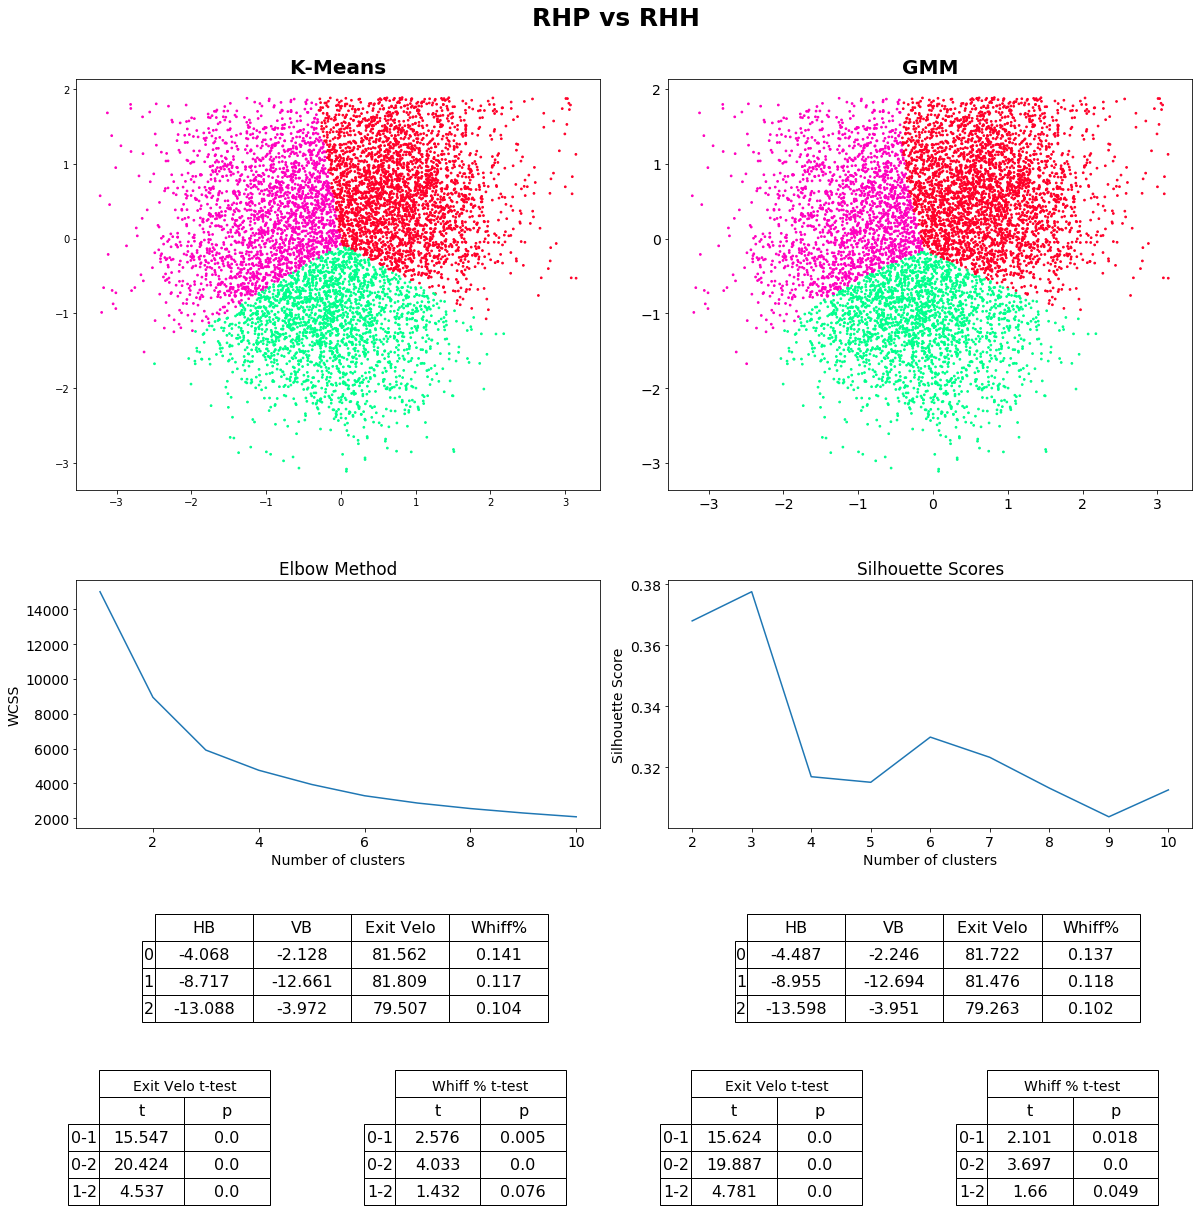

In [12]:
# RHP vs RHH
np.random.seed(123)
data = curveballs_RR
features_break = ['HorzBreak', 'InducedVertBreak']

# Separating out the features
x = data.loc[:, features_break].values
y = data.loc[:, features_break].values
z_k = z_gmm = data

# Standardizing the features
x = g = StandardScaler().fit_transform(x)


# K-Means (3 clusters)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(x)
y_km = kmeans.fit_predict(x)
y_km_jaccard = y_km

data = data.assign(cluster = pd.Series(kmeans.labels_).values)
z_k = z_k.assign(cluster = pd.Series(kmeans.labels_).values)

# K-Means: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_k = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_k = average_values_k.round(3)
test_vals_k = tpval(z_k)
test_vals_k[0] = test_vals_k[0].round(3)
test_vals_k[1] = test_vals_k[1].round(3)


# Gaussian Mixture (3 clusters)
gmm = GaussianMixture(n_components=3)
gmm.fit(g)
y_gmm = gmm.predict(g)
y_gmm_jaccard = y_gmm


data = data.assign(cluster = pd.Series(y_gmm).values)
z_gmm = z_gmm.assign(cluster = pd.Series(y_gmm).values)

# GMM: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_gmm = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_gmm = average_values_gmm.round(3)
test_vals_gmm = tpval(z_gmm)
test_vals_gmm[0] = test_vals_gmm[0].round(3)
test_vals_gmm[1] = test_vals_gmm[1].round(3)



# determining point size by # of data points
if(400 < x.shape[0] < 800): s = 8
elif(x.shape[0] <= 400): s = 20
else:s = 3

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.suptitle(("RHP vs RHH"), fontsize=25, fontweight='bold', y=.89)

# K-Means scatter plot 
ax1 = plt.subplot2grid((8, 4), (0, 0), rowspan=4, colspan=2)
ax1.scatter(x[:, 0], x[:, 1], c = y_km, s = s, cmap = 'gist_rainbow')
plt.title('K-Means', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# GMM scatter plot 
ax2 = plt.subplot2grid((8, 4), (0, 2), rowspan=4, colspan=2)
ax2.scatter(g[:, 0], g[:, 1], c = y_gmm, s = s, cmap = 'gist_rainbow')
plt.title('GMM', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# K-Means elbow method 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
ax3 = plt.subplot2grid((8, 4), (4, 0), rowspan=2, colspan=2)
ax3.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# GMM silhouette 
silhouette_score_values=[]
for i in range(2, 11):
    gmm = GaussianMixture(i, n_init=10, max_iter=300,random_state=0)
    gmm.fit(g)
    y_gmm = gmm.predict(g)
    silhouette_score_values.append(silhouette_score(g, y_gmm ,metric='euclidean', 
                                                    sample_size=None, random_state=None))
ax4 = plt.subplot2grid((8, 4), (4, 2), rowspan=2, colspan=2)
ax4.plot(range(2,11), silhouette_score_values)
plt.title("Silhouette Scores")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# K-Means table of averages 
ax5 = plt.subplot2grid((8, 4), (6, 0), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax5.axis('off')
mpl_table = ax5.table(cellText = average_values_k.values, rowLabels = average_values_k.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM table of averages 
ax6 = plt.subplot2grid((8, 4), (6, 2), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax6.axis('off')
mpl_table = ax6.table(cellText = average_values_gmm.values, rowLabels = average_values_gmm.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means exit velo t test
ax7 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax7.axis('off')
header = ax7.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax7.table(cellText = test_vals_k[0].iloc[:,1:3].values, rowLabels = test_vals_k[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM exit velo t test
ax8 = plt.subplot2grid((8, 4), (7, 2), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax8.axis('off')
header = ax8.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax8.table(cellText = test_vals_gmm[0].iloc[:,1:3].values, rowLabels = test_vals_gmm[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means whiff % t test
ax9 = plt.subplot2grid((8, 4), (7, 1), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax9.axis('off')
header = ax9.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax9.table(cellText = test_vals_k[1].iloc[:,1:3].values, rowLabels = test_vals_k[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM whiff % t test
ax10 = plt.subplot2grid((8, 4), (7, 3), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax10.axis('off')
header = ax10.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax10.table(cellText = test_vals_gmm[1].iloc[:,1:3].values, rowLabels = test_vals_gmm[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)



In [13]:
# Jaccard Score
jaccard(y_km_jaccard, y_gmm_jaccard)

,Cluster 0,Cluster 1,Cluster 2
Score,0.905405,0.929407,0.848678


__*4.2.1 RHP vs. RHH*__

Clustering with only two variables immediately improves interpretability, allowing us to plot and color results according to cluster membership. The WCSS and Silhouette plots once again indicate that three clusters will be ideal for maximizing cohesion and maintaining simplicity. The results once again show 3 curveball types with varying movement profiles. In this case we have a more clear cut 12:6 downward  moving curveball in cluster 2. We then have a tight slider (0) and a more side to side slurve (2). Significance tests suggest that exit velocity is significantly different for all groups, but in practice an average difference below 2 or so mph is not going to make a meaningful impact on in-game results. For RHP vs. RHH, it appears that the more horizontal moving pitch gets weaker contact, but the tighter pitch gets the most swing and miss.


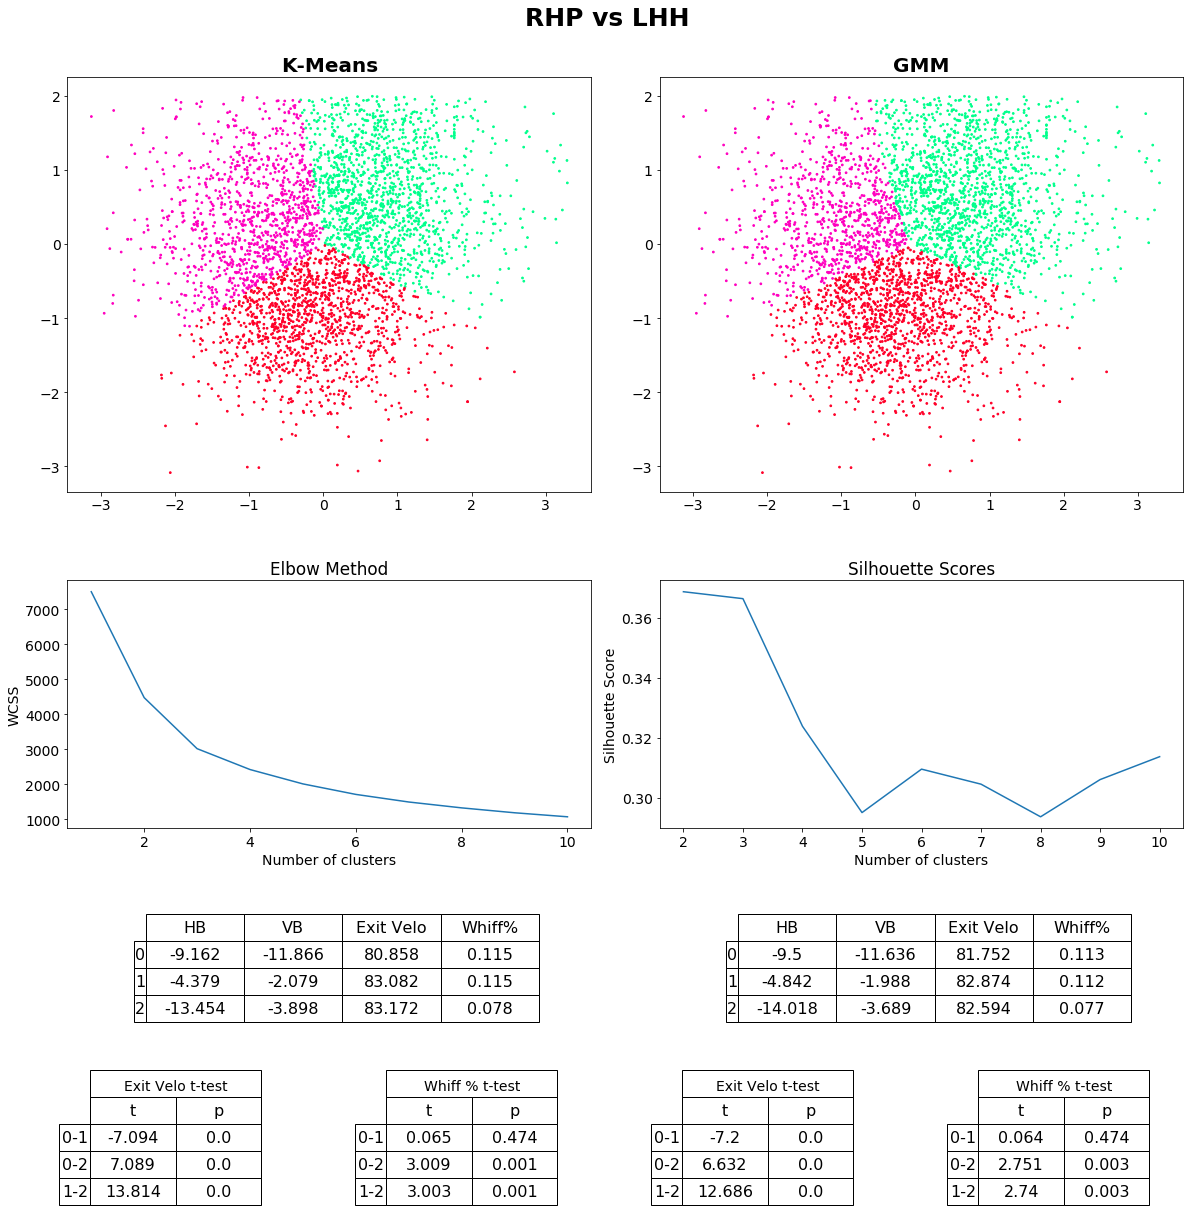

In [14]:
# RHP vs LHH
np.random.seed(31)
data = curveballs_RL
features_break = ['HorzBreak', 'InducedVertBreak']

# Separating out the features
x = data.loc[:, features_break].values
y = data.loc[:, features_break].values
z_k = z_gmm = data

# Standardizing the features
x = g = StandardScaler().fit_transform(x)


# K-Means (3 clusters)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(x)
y_km = kmeans.fit_predict(x)
y_km_jaccard = y_km

data = data.assign(cluster = pd.Series(kmeans.labels_).values)
z_k = z_k.assign(cluster = pd.Series(kmeans.labels_).values)

# K-Means: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_k = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_k = average_values_k.round(3)
test_vals_k = tpval(z_k)
test_vals_k[0] = test_vals_k[0].round(3)
test_vals_k[1] = test_vals_k[1].round(3)


# Gaussian Mixture (3 clusters)
gmm = GaussianMixture(n_components=3)
gmm.fit(g)
y_gmm = gmm.predict(g)
y_gmm_jaccard = y_gmm
data = data.assign(cluster = pd.Series(y_gmm).values)
z_gmm = z_gmm.assign(cluster = pd.Series(y_gmm).values)

# GMM: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_gmm = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_gmm = average_values_gmm.round(3)
test_vals_gmm = tpval(z_gmm)
test_vals_gmm[0] = test_vals_gmm[0].round(3)
test_vals_gmm[1] = test_vals_gmm[1].round(3)



# determining point size by # of data points
if(400 < x.shape[0] < 800): s = 8
elif(x.shape[0] <= 400): s = 20
else:s = 3

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.suptitle(("RHP vs LHH"), fontsize=25, fontweight='bold', y=.89)

# K-Means scatter plot 
ax1 = plt.subplot2grid((8, 4), (0, 0), rowspan=4, colspan=2)
ax1.scatter(x[:, 0], x[:, 1], c = y_km, s = s, cmap = 'gist_rainbow')
plt.title('K-Means', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# GMM scatter plot 
ax2 = plt.subplot2grid((8, 4), (0, 2), rowspan=4, colspan=2)
ax2.scatter(g[:, 0], g[:, 1], c = y_gmm, s = s, cmap = 'gist_rainbow')
plt.title('GMM', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# K-Means elbow method 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
ax3 = plt.subplot2grid((8, 4), (4, 0), rowspan=2, colspan=2)
ax3.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# GMM silhouette 
silhouette_score_values=[]
for i in range(2, 11):
    gmm = GaussianMixture(i, n_init=10, max_iter=300,random_state=0)
    gmm.fit(g)
    y_gmm = gmm.predict(g)
    silhouette_score_values.append(silhouette_score(g, y_gmm ,metric='euclidean', 
                                                    sample_size=None, random_state=None))
ax4 = plt.subplot2grid((8, 4), (4, 2), rowspan=2, colspan=2)
ax4.plot(range(2,11), silhouette_score_values)
plt.title("Silhouette Scores")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# K-Means table of averages 
ax5 = plt.subplot2grid((8, 4), (6, 0), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax5.axis('off')
mpl_table = ax5.table(cellText = average_values_k.values, rowLabels = average_values_k.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM table of averages 
ax6 = plt.subplot2grid((8, 4), (6, 2), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax6.axis('off')
mpl_table = ax6.table(cellText = average_values_gmm.values, rowLabels = average_values_gmm.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means exit velo t test
ax7 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax7.axis('off')
header = ax7.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax7.table(cellText = test_vals_k[0].iloc[:,1:3].values, rowLabels = test_vals_k[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM exit velo t test
ax8 = plt.subplot2grid((8, 4), (7, 2), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax8.axis('off')
header = ax8.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax8.table(cellText = test_vals_gmm[0].iloc[:,1:3].values, rowLabels = test_vals_gmm[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means whiff % t test
ax9 = plt.subplot2grid((8, 4), (7, 1), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax9.axis('off')
header = ax9.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax9.table(cellText = test_vals_k[1].iloc[:,1:3].values, rowLabels = test_vals_k[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM whiff % t test
ax10 = plt.subplot2grid((8, 4), (7, 3), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax10.axis('off')
header = ax10.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax10.table(cellText = test_vals_gmm[1].iloc[:,1:3].values, rowLabels = test_vals_gmm[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)



In [15]:
# Jaccard Score
jaccard(y_km_jaccard, y_gmm_jaccard)

,Cluster 0,Cluster 1,Cluster 2
Score,0.903226,0.907792,0.777052


__*4.2.2 RHP vs LHH*__

Immediately one notices breaking balls perform more poorly against batters of the opposite handedness, with all average exit velocities over 80 mph and generally lower whiff rates. That being said there are still significant differences in performance between clusters. The true curveball (0) with large drop now seems to be the best performer instead of the tight slider (1), especially in terms of producing weak contact. The horizontal moving pitch (2) is considerably worse at inducing whiffs, but is not much different from the tight-moving slider in terms of opponents exit velocity.


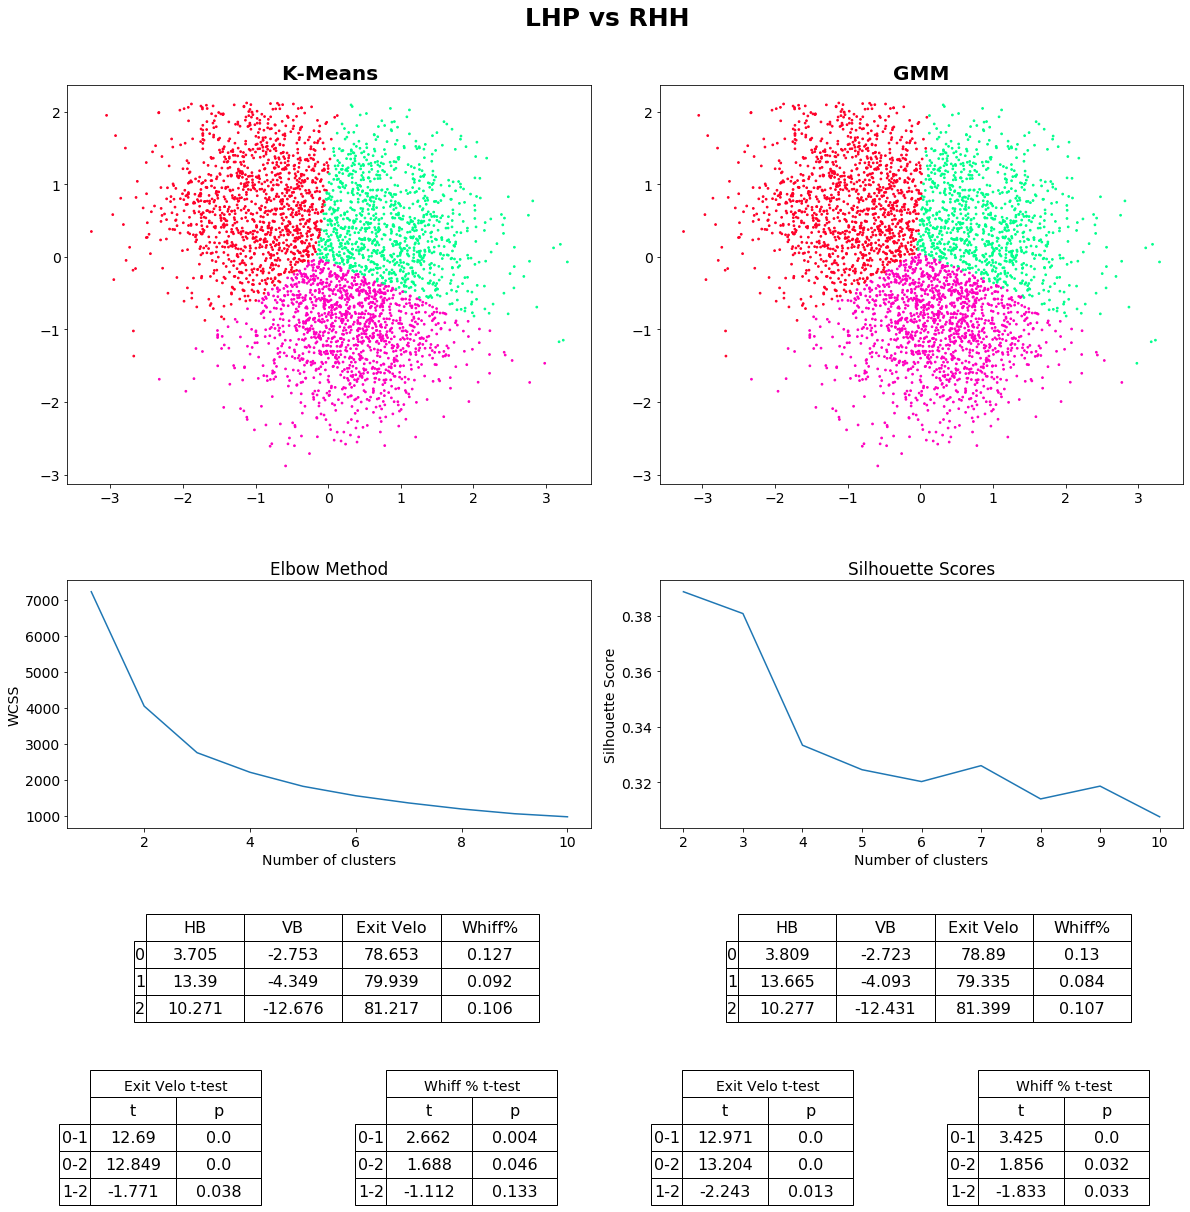

In [16]:
# LHP vs RHH
np.random.seed(10)
data = curveballs_LR
features_break = ['HorzBreak', 'InducedVertBreak']

# Separating out the features
x = data.loc[:, features_break].values
y = data.loc[:, features_break].values
z_k = z_gmm = data

# Standardizing the features
x = g = StandardScaler().fit_transform(x)


# K-Means (3 clusters)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(x)
y_km = kmeans.fit_predict(x)

data = data.assign(cluster = pd.Series(kmeans.labels_).values)
z_k = z_k.assign(cluster = pd.Series(kmeans.labels_).values)

# K-Means: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_k = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_k = average_values_k.round(3)
test_vals_k = tpval(z_k)
test_vals_k[0] = test_vals_k[0].round(3)
test_vals_k[1] = test_vals_k[1].round(3)


# Gaussian Mixture (3 clusters)
gmm = GaussianMixture(n_components=3)
gmm.fit(g)
y_gmm = gmm.predict(g)

data = data.assign(cluster = pd.Series(y_gmm).values)
z_gmm = z_gmm.assign(cluster = pd.Series(y_gmm).values)

# GMM: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_gmm = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_gmm = average_values_gmm.round(3)
test_vals_gmm = tpval(z_gmm)
test_vals_gmm[0] = test_vals_gmm[0].round(3)
test_vals_gmm[1] = test_vals_gmm[1].round(3)



# determining point size by # of data points
if(400 < x.shape[0] < 800): s = 8
elif(x.shape[0] <= 400): s = 20
else:s = 3

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.suptitle(("LHP vs RHH"), fontsize=25, fontweight='bold', y=.89)

# K-Means scatter plot 
ax1 = plt.subplot2grid((8, 4), (0, 0), rowspan=4, colspan=2)
ax1.scatter(x[:, 0], x[:, 1], c = y_km, s = s, cmap = 'gist_rainbow')
plt.title('K-Means', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# GMM scatter plot 
ax2 = plt.subplot2grid((8, 4), (0, 2), rowspan=4, colspan=2)
ax2.scatter(g[:, 0], g[:, 1], c = y_gmm, s = s, cmap = 'gist_rainbow')
plt.title('GMM', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# K-Means elbow method 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
ax3 = plt.subplot2grid((8, 4), (4, 0), rowspan=2, colspan=2)
ax3.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# GMM silhouette 
silhouette_score_values=[]
for i in range(2, 11):
    gmm = GaussianMixture(i, n_init=10, max_iter=300,random_state=0)
    gmm.fit(g)
    y_gmm = gmm.predict(g)
    silhouette_score_values.append(silhouette_score(g, y_gmm ,metric='euclidean', 
                                                    sample_size=None, random_state=None))
ax4 = plt.subplot2grid((8, 4), (4, 2), rowspan=2, colspan=2)
ax4.plot(range(2,11), silhouette_score_values)
plt.title("Silhouette Scores")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# K-Means table of averages 
ax5 = plt.subplot2grid((8, 4), (6, 0), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax5.axis('off')
mpl_table = ax5.table(cellText = average_values_k.values, rowLabels = average_values_k.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM table of averages 
ax6 = plt.subplot2grid((8, 4), (6, 2), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax6.axis('off')
mpl_table = ax6.table(cellText = average_values_gmm.values, rowLabels = average_values_gmm.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means exit velo t test
ax7 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax7.axis('off')
header = ax7.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax7.table(cellText = test_vals_k[0].iloc[:,1:3].values, rowLabels = test_vals_k[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM exit velo t test
ax8 = plt.subplot2grid((8, 4), (7, 2), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax8.axis('off')
header = ax8.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax8.table(cellText = test_vals_gmm[0].iloc[:,1:3].values, rowLabels = test_vals_gmm[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means whiff % t test
ax9 = plt.subplot2grid((8, 4), (7, 1), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax9.axis('off')
header = ax9.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax9.table(cellText = test_vals_k[1].iloc[:,1:3].values, rowLabels = test_vals_k[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM whiff % t test
ax10 = plt.subplot2grid((8, 4), (7, 3), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax10.axis('off')
header = ax10.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax10.table(cellText = test_vals_gmm[1].iloc[:,1:3].values, rowLabels = test_vals_gmm[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

In [17]:
# Jaccard Score
jaccard(y_km_jaccard, y_gmm_jaccard)

,Cluster 0,Cluster 1,Cluster 2
Score,0.903226,0.907792,0.777052


__*4.2.3 LHP vs RHH*__

For LHP vs. RHH matchups, pitcher performance is much better than it was for RHP vs. LHH. This is likely due to the fact that there are fewer left handed pitchers so hitters have less experience against them then they do against RHP. Interestingly, the true curveball (2) is no longer the best pitch, with higher exit velocity and average whiff rate scores. The best pitch appears to be the tight slider (0), which has the lowest exit velocity and whiff rates at a statistically significant level. The horizontal (1) pitch was once again the weakest performer across the board.

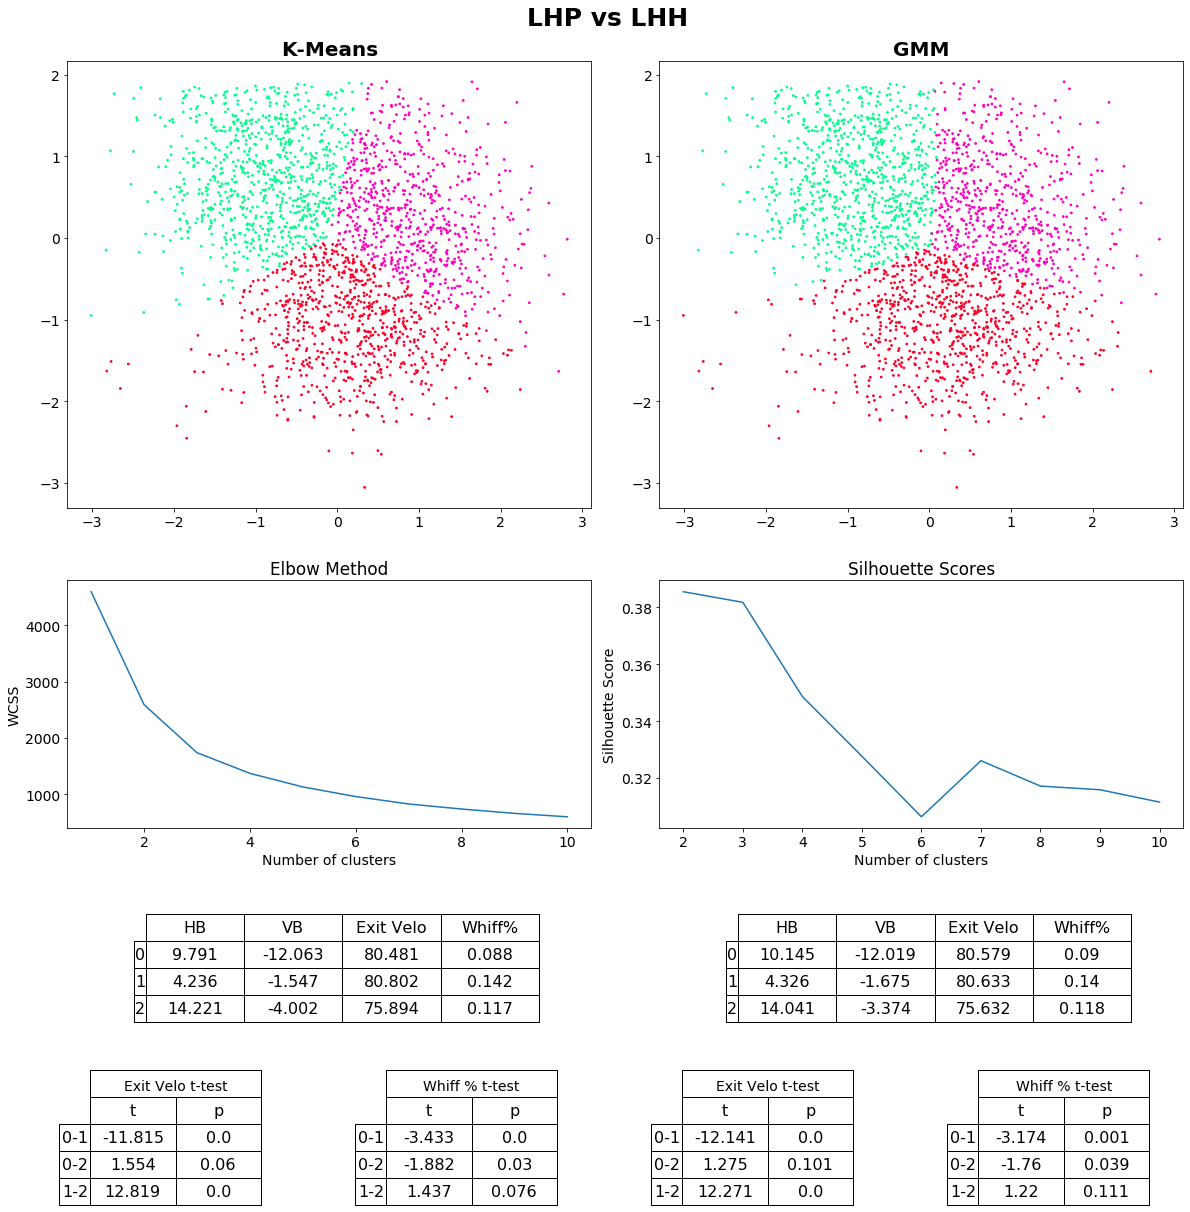

In [18]:
# LHP vs LHH
np.random.seed(31)
data = curveballs_LL
features_break = ['HorzBreak', 'InducedVertBreak']

# Separating out the features
x = data.loc[:, features_break].values
y = data.loc[:, features_break].values
z_k = z_gmm = data

# Standardizing the features
x = g = StandardScaler().fit_transform(x)


# K-Means (3 clusters)
kmeans = KMeans(n_clusters = 3)
kmeans.fit(x)
y_km = kmeans.fit_predict(x)
y_km_jaccard = y_km
data = data.assign(cluster = pd.Series(kmeans.labels_).values)
z_k = z_k.assign(cluster = pd.Series(kmeans.labels_).values)

# K-Means: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_k = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_k = average_values_k.round(3)
test_vals_k = tpval(z_k)
test_vals_k[0] = test_vals_k[0].round(3)
test_vals_k[1] = test_vals_k[1].round(3)


# Gaussian Mixture (3 clusters)
gmm = GaussianMixture(n_components=3)
gmm.fit(g)
y_gmm = gmm.predict(g)
y_gmm_jaccard = y_gmm
data = data.assign(cluster = pd.Series(y_gmm).values)
z_gmm = z_gmm.assign(cluster = pd.Series(y_gmm).values)

# GMM: computing mean HB, VB, Exit Velo, and Whiff % for each cluster
average_values_gmm = data.groupby('cluster').agg('mean')[['HorzBreak', 'InducedVertBreak','ExitSpeed','Whiff']]
average_values_gmm = average_values_gmm.round(3)
test_vals_gmm = tpval(z_gmm)
test_vals_gmm[0] = test_vals_gmm[0].round(3)
test_vals_gmm[1] = test_vals_gmm[1].round(3)


# determining point size by # of data points
if(400 < x.shape[0] < 800): s = 8
elif(x.shape[0] <= 400): s = 20
else:s = 3

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.suptitle(("LHP vs LHH"), fontsize=25, fontweight='bold', y=.89)

# K-Means scatter plot 
ax1 = plt.subplot2grid((8, 4), (0, 0), rowspan=4, colspan=2)
ax1.scatter(x[:, 0], x[:, 1], c = y_km, s = s, cmap = 'gist_rainbow')
plt.title('K-Means', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# GMM scatter plot 
ax2 = plt.subplot2grid((8, 4), (0, 2), rowspan=4, colspan=2)
ax2.scatter(g[:, 0], g[:, 1], c = y_gmm, s = s, cmap = 'gist_rainbow')
plt.title('GMM', fontsize = 20, fontweight='bold')
plt.rc('font', size=14)
plt.gca().set_aspect('equal', adjustable='box')

# K-Means elbow method 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
ax3 = plt.subplot2grid((8, 4), (4, 0), rowspan=2, colspan=2)
ax3.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# GMM silhouette 
silhouette_score_values=[]
for i in range(2, 11):
    gmm = GaussianMixture(i, n_init=10, max_iter=300,random_state=0)
    gmm.fit(g)
    y_gmm = gmm.predict(g)
    silhouette_score_values.append(silhouette_score(g, y_gmm ,metric='euclidean', 
                                                    sample_size=None, random_state=None))
ax4 = plt.subplot2grid((8, 4), (4, 2), rowspan=2, colspan=2)
ax4.plot(range(2,11), silhouette_score_values)
plt.title("Silhouette Scores")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# K-Means table of averages 
ax5 = plt.subplot2grid((8, 4), (6, 0), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax5.axis('off')
mpl_table = ax5.table(cellText = average_values_k.values, rowLabels = average_values_k.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM table of averages 
ax6 = plt.subplot2grid((8, 4), (6, 2), rowspan=1, colspan=2)
bbox=[0.15, -.5, .75, 1]
ax6.axis('off')
mpl_table = ax6.table(cellText = average_values_gmm.values, rowLabels = average_values_gmm.index, 
                      bbox=bbox, colLabels=["HB", "VB", "Exit Velo", "Whiff%"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means exit velo t test
ax7 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax7.axis('off')
header = ax7.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax7.table(cellText = test_vals_k[0].iloc[:,1:3].values, rowLabels = test_vals_k[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM exit velo t test
ax8 = plt.subplot2grid((8, 4), (7, 2), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax8.axis('off')
header = ax8.table(cellText=[['']],
                  colLabels=['Exit Velo t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax8.table(cellText = test_vals_gmm[0].iloc[:,1:3].values, rowLabels = test_vals_gmm[0].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# K-Means whiff % t test
ax9 = plt.subplot2grid((8, 4), (7, 1), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax9.axis('off')
header = ax9.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax9.table(cellText = test_vals_k[1].iloc[:,1:3].values, rowLabels = test_vals_k[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

# GMM whiff % t test
ax10 = plt.subplot2grid((8, 4), (7, 3), rowspan=1, colspan=1)
bbox=[0.1, -.9, .75, 1]
ax10.axis('off')
header = ax10.table(cellText=[['']],
                  colLabels=['Whiff % t-test'], loc = 'top', bbox = [0.1, -.25, .75, .6])
mpl_table = ax10.table(cellText = test_vals_gmm[1].iloc[:,1:3].values, rowLabels = test_vals_gmm[1].iloc[:,0], 
                      bbox=bbox, colLabels=["t", "p"], cellLoc = 'center')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(16)

In [19]:
# Jaccard Score
jaccard(y_km_jaccard, y_gmm_jaccard)

,Cluster 0,Cluster 1,Cluster 2
Score,0.90119,0.937209,0.882768


__*4.2.4 LHP vs LHH*__

The results of the LHP vs. LHH clustering analysis mirror those of RHP vs. RHH. The best performing pitch based on swing and miss is the slider with the smallest movement, while the pitch yielding the lowest average exit velocities was the pitch with the most horizontal (glove-side) break.


__*4.2.5 Overview*__

Overall results of movement clustering show that the most successful pitch types and movement profiles vary depending on match-ups. When facing a batter that hits from the same side that the pitcher throws, a pitch with less total movement is going to induce the most swing and miss, while a pitch with a lot of glove-side movement (horizontally away from the batter) is going to produce the weakest contact on average. RHPs facing LHHs are going to get the weakest contact with a true, vertical curveball and about equal swing and miss compared to the tight slider, but will see whiff rates drop significantly if they throw the horizontally moving pitch, without much benefit in the form of weaker contact. For LHPs facing RHHs, the horizontal curveball/slider is once again the weakest performer, but the tight, short slider now overtakes the true curveball as the most effective pitch, with the lowest exit velocities and highest whiff rates.
 
The Jaccard indices measure the similarity of equivalent clusters using different methods. Values were generally high (near 1), although less though for the third cluster, suggesting that there is some difference in groups when comparing K-Means to GMM but nothing incredibly distinct. The plots also look similar, giving more evidence to the fact that the methods yielded similar results. I think in our case however, GMM is a more appropriate model. This is because there are not really any clear clusters evident in the data, at least for the clustering based on Induced Vertical Break and Horizontal Break. The plots show one large mass without necessarily giving the idea of smaller groups within the data. This fact is confirmed by the relatively smooth WCCS plots. GMM does not need to specify assignment to one group as does K-Means, so given our unique dataset, it is a more appropriate fit in that it acknowledges uncertainty about membership for a solid amount of points in the dataset.
 
Another important aspect of our analysis is the concept of statistical significance. For example, exit velocities were almost always proven to be significantly different between clusters, but this doesn’t necessarily mean that we have actionable evidence. For example, for K-Means clustering looking at LHP vs LHH, clusters 0 and 1 had significantly different average exit velocities, but the difference was only .4 mph. This difference is so minute that it does not really indicate a better chance of success for group 0 over group 1. These considerations demonstrate why it is important to interpret statistical information in the context of its particular usefulness.

# 5 Conclusion/Further Discussion
The goal of this project was to compare the success rate of different types of curveballs with the help of unsupervised cluster analysis. We were able to achieve the desired results, but with several roadblocks. First and foremost, the data simply does not appear to cluster very well, especially in two dimensions, which suggests that maybe cluster analysis is not perfect in this situation, and that a continuous regression that avoids hard classification could be more effective. We also ran into the issue of which pitch types we were truly analyzing. Due to differences and subjectivity in tagging across the NCAA, many pitches that move more like sliders were tagged as curveballs and therefore included in our analysis. This meant less of a focus on the particular aspects of true curveballs and more of a comparison of all breaking balls, which was not the original goal.

The primary conclusions of this report were that based on each match-up, each type of curveball or breaking ball might have varying levels of effectiveness. Pitches with smaller movement profiles and faster velocities, which act more like sliders, seemed to have the most success overall, while horizontally moving pitches were mostly effective vs batters of the same handedness as the pitcher, and true downward breaking curveballs were only effective in RHP vs LHH match-ups.

Now that we have laid a foundation for clustering analysis of pitches based on ball-tracking data there is potential to take these inquiries even further. A first step would be to conduct similar analysis with different methods such as regression. We could also expand cluster analysis to other pitch types, or aggregate data differently, possibly looking into cluster analysis on an individual pitcher basis instead of on each pitch. Additionally, we believe that there exists the possibility to apply similar analysis but with different measures of success (opponents wOBA, pitch value, batted ball score) and to investigate differences in success based on more situational factors such as count, inning, game situation, etc. At the very least we hope that our analysis has shed some light onto how statistical methods can be applied to both pitch analysis and eventually design.


# 6 References

[1] D. Carty, “On Curveballs,” The Hardball Times, 08-Aug-2008. [Online]. Available: https://tht.fangraphs.com/working-title-on-location-and-effectiveness-of-the-curveball/. [Accessed: 06-Dec-2019].

[2] T. Sawchik, “MLB Curves And Sliders Have Gotten Alarmingly Nasty,” FiveThirtyEight, 23-May-2019. [Online]. Available: https://fivethirtyeight.com/features/mlb-curves-and-sliders-have-gotten-alarmingly-nasty/. [Accessed: 06-Dec-2019].
